In [68]:
import numpy as np
import pandas as pd
from collections import OrderedDict
import itertools
import statsmodels.formula.api as smf
import sys
import time
import requests
# Plotting packages
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns
import datetime

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.api import acf, pacf, graphics
from io import BytesIO
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [69]:
#electricity consumption data
electr_residential = pd.read_csv('../../../data/tidy/residential-electricity-2016to2022.csv') 
electr_commer_indust = pd.read_csv('../../../data/tidy/commercial-electricity-2016to2022.csv')

electr_commer_indust = electr_commer_indust.iloc[::-1]

# If you want to reset the index after flipping, you can do:
electr_commer_indust.reset_index(drop=True, inplace=True)
electr_commer_indust.set_index('Unnamed: 0', inplace=True)
electr_commer_indust.index.name = 'index'
electr_commer_indust.drop(electr_commer_indust.columns[0], axis=1, inplace=True)


electr_residential = electr_residential.iloc[::-1]

# If you want to reset the index after flipping, you can do:
electr_residential.reset_index(drop=True, inplace=True)
electr_residential.set_index('Unnamed: 0', inplace=True)
electr_residential.index.name = 'index'
electr_residential.drop(electr_residential.columns[0], axis=1, inplace=True)

electric_results = electr_commer_indust+electr_residential

#assuming constant emissions factor
Total_EF = 543.852

electric_results = electric_results/1000*Total_EF/2204.62/1000000 #unit (MMTCO2e)

# Define new column names
new_column_names = ['New Haven (MMTCO2e)', 'Hartford (MMTCO2e)', 'Bridgeport (MMTCO2e)']

# Assign new column names to the DataFrame
electric_results.columns = new_column_names

electric_results.index.name = 'year'


electric_results.index = pd.to_datetime(electric_results.index, format='%Y')
electric_results.index.freq = 'AS'
df=electric_results
df

,New Haven (MMTCO2e),Hartford (MMTCO2e),Bridgeport (MMTCO2e)
year,,,
2016-01-01,1.430073,1.924097,1.792147
2017-01-01,1.355028,2.231089,1.706469
2018-01-01,1.449108,2.108849,1.726713
2019-01-01,1.374215,1.844642,1.674141
2020-01-01,1.303380,1.756536,1.590311
2021-01-01,1.314940,1.790219,1.671623
2022-01-01,1.353627,1.842788,1.688185


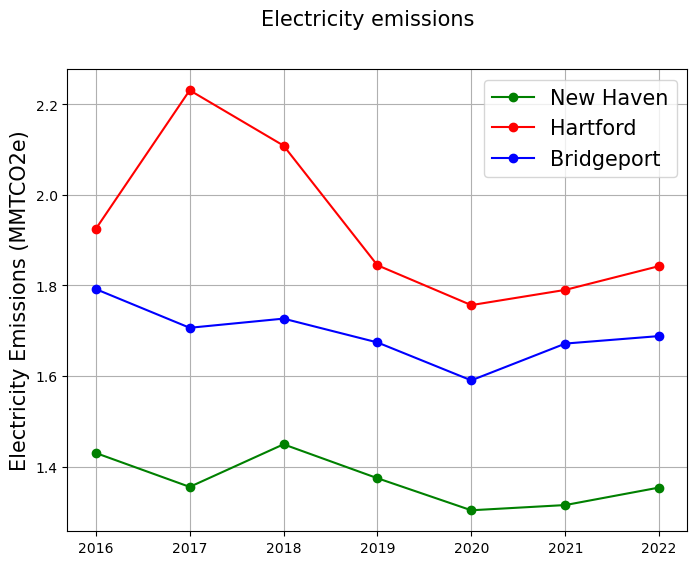

In [70]:
fig = plt.figure(figsize=(8,6))
fig.suptitle('Electricity emissions',fontsize=15)
actual, = plt.plot(df.index, df['New Haven (MMTCO2e)'], 'go-', label='New Haven')
actual, = plt.plot(df.index, df['Hartford (MMTCO2e)'], 'ro-', label='Hartford')
actual, = plt.plot(df.index, df['Bridgeport (MMTCO2e)'], 'bo-', label='Bridgeport')
#plt.xlabel('Year',fontsize=18)
plt.ylabel('Electricity Emissions (MMTCO2e)',fontsize=15)
#plt.xticks(np.arange(min(electr_residential.index), max(electr_residential.index)+1, 1)) 
plt.legend(fontsize=15)
plt.grid()
#plt.savefig('images/avetemp.png',bbox_inches='tight')
plt.savefig('../../../figures/electricity-emissions-historical-change.png', dpi=600, bbox_inches='tight')

In [71]:
#split the test and trainig set
split_index = round(len(df)*0.7)
df_train = df.iloc[:split_index].copy()
df_test = df.iloc[split_index:].copy()


df_train.index.freq = 'AS'
df_test.index.freq = 'AS'

In [72]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(df['Hartford (MMTCO2e)'])
# Output the results
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])

ADF Statistic: -9.662515
p-value: 0.000000


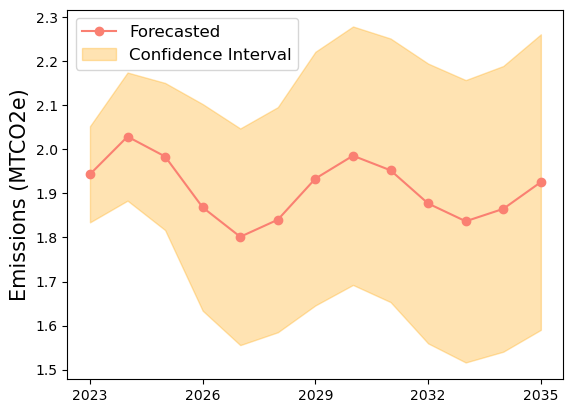

In [74]:
def arima_forecast(train, test, order,forecast_horizon,plot_file,color1,color2):
    # Fit the SARIMA model with the optimal parameters
    mod = sm.tsa.arima.ARIMA(train, order=order)
    #what are existing forecasting, few slides 
    res = mod.fit()

    forecast = res.forecast(steps=forecast_horizon)

    # Calculate the confidence interval
    forecast_object = res.get_forecast(steps=forecast_horizon)
    confidence_interval = forecast_object.conf_int()

    forecast.index = range(2023, 2023 + forecast_horizon)
    plt.plot(forecast.index, forecast, marker='o', color=color1, label='Forecasted')

    # Plot the confidence interval
    plt.fill_between(forecast.index, confidence_interval.iloc[:, 0], confidence_interval.iloc[:, 1], color=color2, alpha=0.3, label='Confidence Interval')

    plt.ylabel('Emissions (MTCO2e)', fontsize=15)
    plt.legend(fontsize=12, loc='upper left')

    # Define the interval between x-ticks
    x_tick_interval = 3 # Change this value to set the desired interval

# Set x-ticks with the specified interval
    plt.xticks(range(2023, 2023 + forecast_horizon, x_tick_interval))

    # Save the plot
    plt.savefig(plot_file)

    return res.summary(),forecast,confidence_interval

HEM_train = df_train['Hartford (MMTCO2e)']
HEM_test = df_test['Hartford (MMTCO2e)']
HEM_data = df['Hartford (MMTCO2e)']
plot_file = '../../../figures/hartford-forecast-emissions-electricity.png'  # File to save the plot

HEM_summary,HEM_forecast,HEM_confidence_interval=arima_forecast(HEM_data, HEM_test,(2,0,2),13, plot_file,'salmon','orange')#chagne the function name. make function shorter; call old function in new function

In [75]:
def arima_test_data_performance_metrics(train, test,order):
    # Fit the SARIMA model with the optimal parameters
    mod = sm.tsa.arima.ARIMA(train, order=order)
    #what are existing forecasting, few slides 
    res = mod.fit()

    test_forecast = res.get_prediction(start=len(train), end=len(train)+len(test)-1)
    test_forecast_mean = test_forecast.predicted_mean

    new_index = range(2023-len(test),2023)
    test_forecast_df = pd.DataFrame(list(test_forecast_mean.items()), columns=['Year', 'Emissions (MMTCO2e)'])
    test_forecast_df['Year'] = new_index


    # Set the 'Year' column as the index
    test_forecast_df.set_index('Year', inplace=True)
    
    test_forecast_df.index = pd.to_datetime(test_forecast_df.index, format='%Y')


    actual_values = test
    predicted_values = test_forecast_df['Emissions (MMTCO2e)']

    mae = mean_absolute_error(actual_values, predicted_values)
    rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
    mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100

    return mae, rmse, mape

HEM_train = df_train['Hartford (MMTCO2e)']
HEM_test = df_test['Hartford (MMTCO2e)']
mae, rmse, mape = arima_test_data_performance_metrics(HEM_train, HEM_test,(2,0,1))
print(mae)
print(rmse)
print(mape)

0.2970671725904781
0.30627967203415396
16.297813711209038


C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


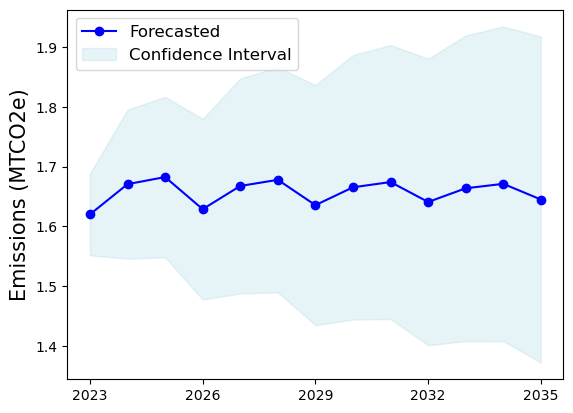

In [76]:
BSN_train = df_train['Bridgeport (MMTCO2e)']
BSN_test = df_test['Bridgeport (MMTCO2e)']
BSN_data = df['Bridgeport (MMTCO2e)']
plot_file = '../../../figures/bridgeport-forecast-emissions-electricity.png'  # File to save the plot

BSN_summary,BSN_forecast,BSN_confidence_interval=arima_forecast(BSN_data, BSN_test,(2,1,2),13, plot_file,'blue','lightblue')#chagne the function name. make function shorter; call old function in new function

In [77]:
mae, rmse, mape = arima_test_data_performance_metrics(BSN_train, BSN_test,(1,0,0))
print(mae,rmse, mape)

0.01899702068684872 0.019610674085913233 1.1322957223406003


C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


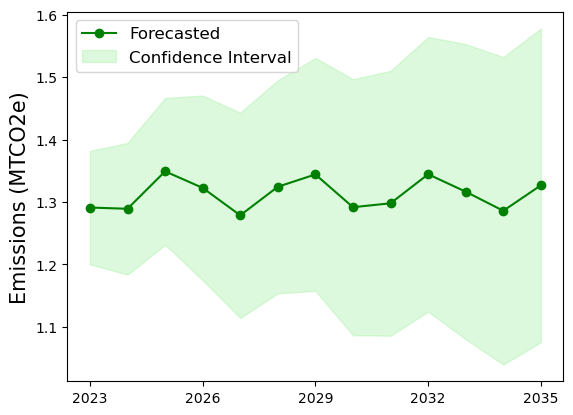

In [78]:
NHM_train = df_train['New Haven (MMTCO2e)']
NHM_test = df_test['New Haven (MMTCO2e)']
NHM_data = df['New Haven (MMTCO2e)']
plot_file = '../../../figures/newhaven-forecast-emissions-electricity.png'  # File to save the plot

NHM_summary,NHM_forecast,NHM_confidence_interval=arima_forecast(NHM_data, NHM_test, (2,1,2),13, plot_file,'green','lightgreen')#chagne the function name. make function shorter; call old function in new function

In [79]:
NHM_train = df_train['New Haven (MMTCO2e)']
NHM_test = df_test['New Haven (MMTCO2e)']
mae, rmse, mape = arima_test_data_performance_metrics(NHM_train, NHM_test,(0,0,1))
print(mae, rmse, mape)

0.07790192121218187 0.08975899155998376 5.888163982815773


In [80]:
def test_train_fitting_VMT(train,test,order):
    # Forecast on training data
    mod = sm.tsa.arima.ARIMA(train, order=order)
    res = mod.fit()
    
    train_forecast = res.get_prediction(start=0, end=len(train)-1)
    train_forecast_mean = train_forecast.predicted_mean.iloc[1:]
    #train_conf_int = train_forecast.conf_int().iloc[1:]

    test_forecast = res.get_prediction(start=len(train), end=len(train)+len(test)-1)
    test_forecast_mean = test_forecast.predicted_mean
    #test_conf_int = test_forecast.conf_int()
    
    return train_forecast_mean,test_forecast_mean
    
    
HEM_train = df_train['Hartford (MMTCO2e)']
HEM_test = df_test['Hartford (MMTCO2e)']
train_forecast_mean_HEM,test_forecast_mean_HEM=test_train_fitting_VMT(HEM_train,HEM_test,(2,0,1))

In [81]:
NHM_train = df_train['New Haven (MMTCO2e)']
NHM_test = df_test['New Haven (MMTCO2e)']
train_forecast_mean_NHM,test_forecast_mean_NHM=test_train_fitting_VMT(NHM_train,NHM_test,(1,0,0))

In [82]:
BSN_train = df_train['Bridgeport (MMTCO2e)']
BSN_test = df_test['Bridgeport (MMTCO2e)']
train_forecast_mean_BSN,test_forecast_mean_BSN=test_train_fitting_VMT(BSN_train,BSN_test,(0,1,0))

In [83]:
def plot_train_test_forecast(train,test,emissions_train,emissions_test,forecast,plot_file,confidence_interval,color,plot_title):
    plt.figure(figsize=(12, 6))

    #combine the test and train data together
    concatenated_observed = pd.concat([train,test])

    #combine the predicted test and train data together
    concatenated_predicted = pd.concat([emissions_train, emissions_test])
    forecast.index = pd.to_datetime(forecast.index, format='%Y')
    
    #combined_index = np.concatenate([concatenated_observed.index, forecast.index])


    #plot the observed value
    plt.plot(concatenated_observed.index, concatenated_observed, marker='o',label='Observed', color='green')


    #plot the predicted value
    plt.plot(concatenated_predicted.index, concatenated_predicted,marker='o', label='Fitted', color='red', linestyle='--')

    plt.plot(forecast.index, forecast, marker='o', color='blue', label='Forecasted')
    # Plot confidence bands for training data
    #plt.fill_between(concatenated_interval.index, concatenated_interval.iloc[:, 0], concatenated_interval.iloc[:, 1], color='orange', alpha=0.2)
    plt.fill_between(forecast.index, confidence_interval.iloc[:, 0], confidence_interval.iloc[:, 1], color=color, alpha=0.3, label='Confidence Interval')

    #combine the index

    plt.title(plot_title, fontsize=18)
    # Adjust x-axis ticks and labels
    #plt.xticks(combined_index, rotation=45)

    #plt.xlabel('Time', fontsize=16)
    plt.ylabel('GHG Emissions (MMTCO2e)', fontsize=20)
    plt.legend(fontsize=16)

    # Set x-axis and y-axis tick labels with fontsize
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    

    # Add a vertical line at the x-axis for the year 2016
    plt.axvline(x=datetime.datetime(2022, 1, 1), color='green', linestyle='--', label='Year 2022 (X-axis)')

    plt.savefig(plot_file, dpi=600, bbox_inches='tight')

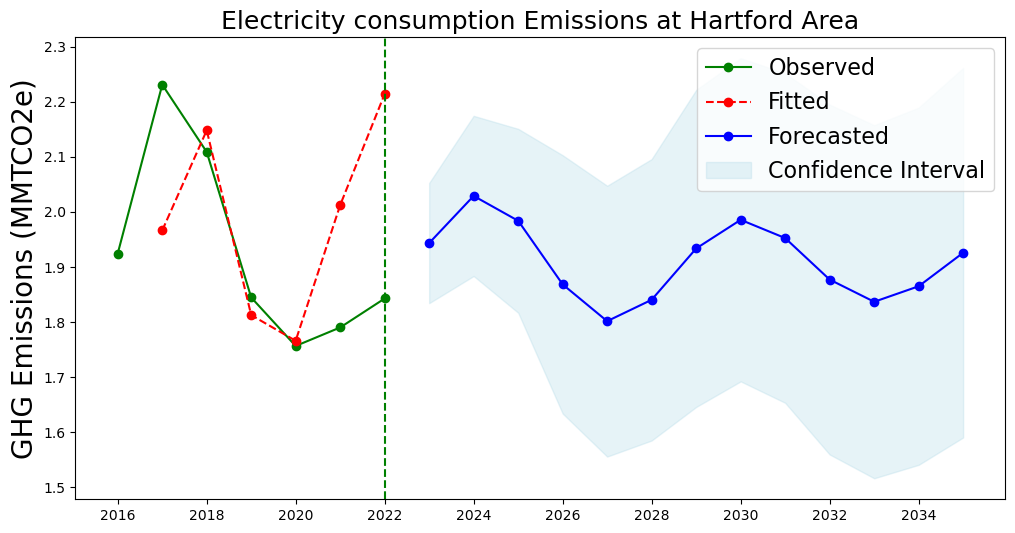

In [84]:
plot_file = '../../../figures/Hartford_train_test_electricity.png'
plot_title ="Electricity consumption Emissions at Hartford Area"
plot_train_test_forecast(HEM_train,HEM_test,train_forecast_mean_HEM,test_forecast_mean_HEM,HEM_forecast,plot_file,HEM_confidence_interval,'lightblue',plot_title)

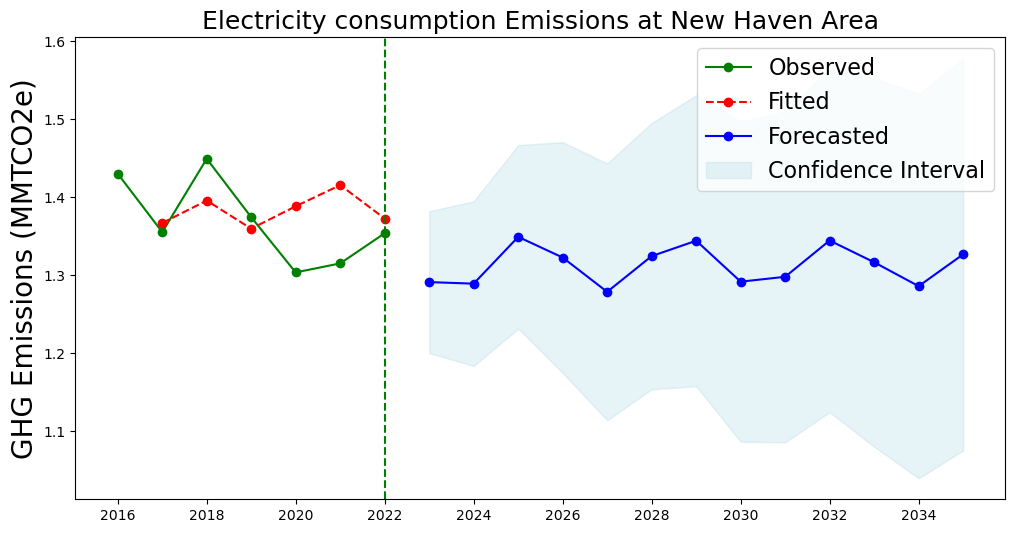

In [85]:
plot_file = '../../../figures/NewHaven_train_test_electricity.png'
plot_title ="Electricity consumption Emissions at New Haven Area"
plot_train_test_forecast(NHM_train,NHM_test,train_forecast_mean_NHM,test_forecast_mean_NHM,NHM_forecast,plot_file,NHM_confidence_interval,'lightblue',plot_title)

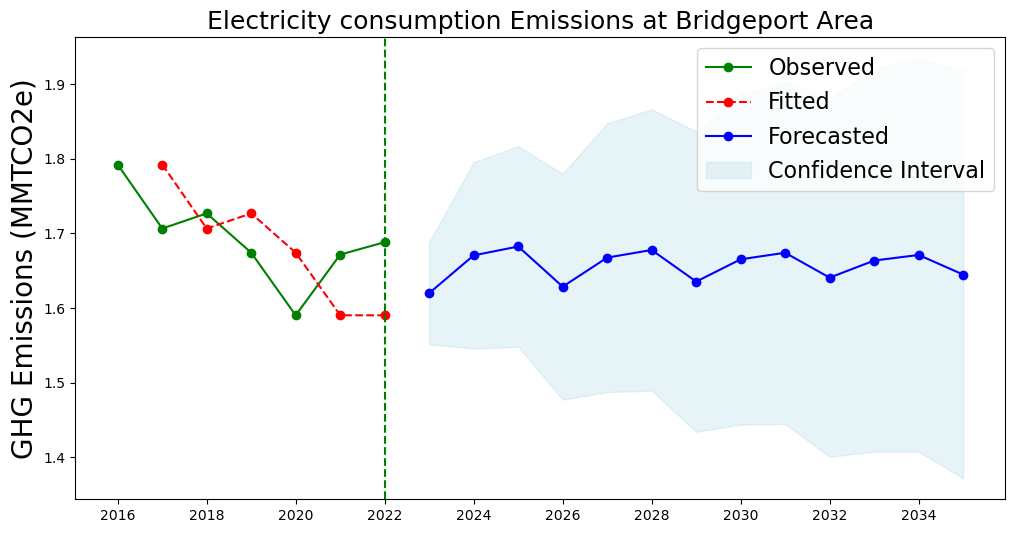

In [86]:
plot_file = '../../../figures/Bridgeport_train_test_electricity.png'
plot_title ="Electricity consumption Emissions at Bridgeport Area"
plot_train_test_forecast(BSN_train,BSN_test,train_forecast_mean_BSN,test_forecast_mean_BSN,BSN_forecast,plot_file,BSN_confidence_interval,'lightblue',plot_title)

In [87]:
#look at: brewercolors; set1 & set3 

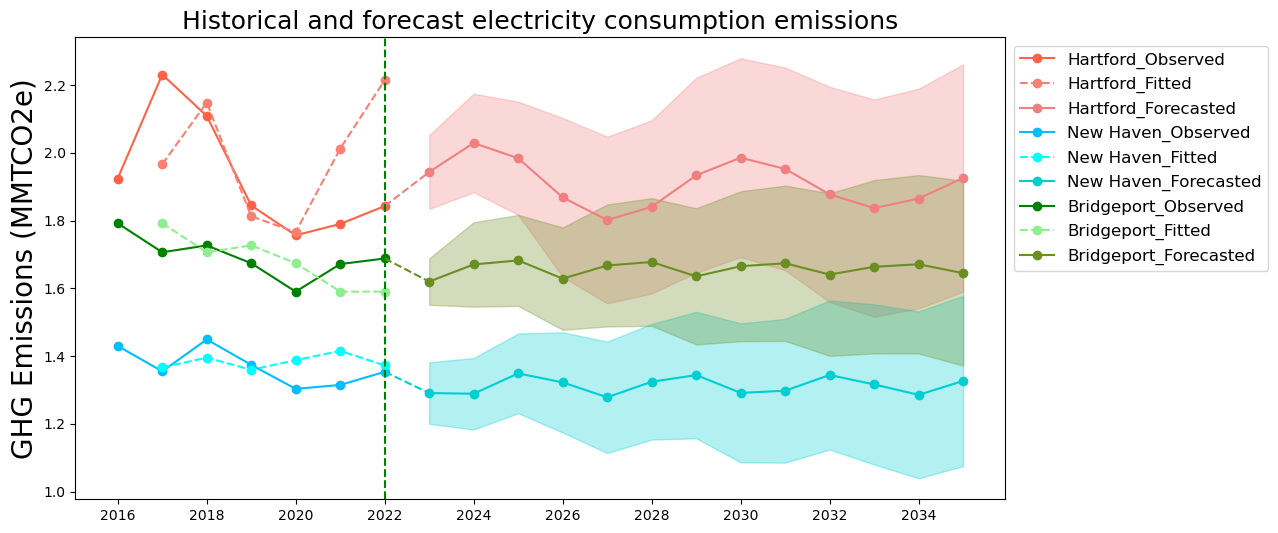

In [88]:
plt.figure(figsize=(12, 6))

concatenated_observed = pd.concat([HEM_train,HEM_test])
concatenated_predicted = pd.concat([train_forecast_mean_HEM, test_forecast_mean_HEM])
HEM_forecast.index = pd.to_datetime(HEM_forecast.index, format='%Y')
plt.plot(concatenated_observed.index, concatenated_observed, marker='o',label='Hartford_Observed', color='tomato')
plt.plot(concatenated_predicted.index, concatenated_predicted,marker='o', label='Hartford_Fitted', color='salmon', linestyle='--')

plt.plot(HEM_forecast.index, HEM_forecast, marker='o', color='lightcoral', label='Hartford_Forecasted')
plt.fill_between(HEM_forecast.index, HEM_confidence_interval.iloc[:, 0], HEM_confidence_interval.iloc[:, 1], color='lightcoral', alpha=0.3)

# Add lines to connect observed data with forecasted data
plt.plot([concatenated_observed.index[-1], HEM_forecast.index[0]], [concatenated_observed.iloc[-1], HEM_forecast.iloc[0]], color='lightcoral', linestyle='--')



concatenated_observed = pd.concat([NHM_train,NHM_test])
concatenated_predicted = pd.concat([train_forecast_mean_NHM, test_forecast_mean_NHM])
NHM_forecast.index = pd.to_datetime(NHM_forecast.index, format='%Y')
plt.plot(concatenated_observed.index, concatenated_observed, marker='o',label='New Haven_Observed', color='deepskyblue')
plt.plot(concatenated_predicted.index, concatenated_predicted,marker='o',label='New Haven_Fitted', color='cyan', linestyle='--')

plt.plot(NHM_forecast.index, NHM_forecast, marker='o', color='darkturquoise', label='New Haven_Forecasted')
plt.fill_between(NHM_forecast.index, NHM_confidence_interval.iloc[:, 0], NHM_confidence_interval.iloc[:, 1], color='darkturquoise', alpha=0.3)

# Add lines to connect observed data with forecasted data
plt.plot([concatenated_observed.index[-1], NHM_forecast.index[0]], [concatenated_observed.iloc[-1], NHM_forecast.iloc[0]], color='darkturquoise', linestyle='--')

concatenated_observed = pd.concat([BSN_train,BSN_test])
concatenated_predicted = pd.concat([train_forecast_mean_BSN, test_forecast_mean_BSN])
BSN_forecast.index = pd.to_datetime(BSN_forecast.index, format='%Y')
plt.plot(concatenated_observed.index, concatenated_observed, marker='o',label='Bridgeport_Observed', color='green')
plt.plot(concatenated_predicted.index, concatenated_predicted,marker='o', label='Bridgeport_Fitted', color='lightgreen', linestyle='--')

plt.plot(BSN_forecast.index, BSN_forecast, marker='o', color='olivedrab', label='Bridgeport_Forecasted')
plt.fill_between(BSN_forecast.index, BSN_confidence_interval.iloc[:, 0], BSN_confidence_interval.iloc[:, 1], color='olivedrab', alpha=0.3)

# Add lines to connect observed data with forecasted data
plt.plot([concatenated_observed.index[-1], BSN_forecast.index[0]], [concatenated_observed.iloc[-1], BSN_forecast.iloc[0]], color='olivedrab', linestyle='--')


plt.title('Historical and forecast electricity consumption emissions', fontsize=18)
plt.ylabel('GHG Emissions (MMTCO2e)', fontsize=20)
plt.legend(fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))

# Set x-axis and y-axis tick labels with fontsize
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)


# Add a vertical line at the x-axis for the year 2016
plt.axvline(x=datetime.datetime(2022, 1, 1), color='green', linestyle='--', label='Year 2022 (X-axis)')

plt.savefig('../../../figures/electricity_forecast.png', dpi=600, bbox_inches='tight')